In [1]:
#!/usr/bin/python
# updated DBR 11/2023 #

%matplotlib inline

import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#for mixed effects models
import statsmodels.api as sm
import statsmodels.formula.api as smf

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

sns.set_style("ticks")


In [2]:
#get the data
#note I took all zeros and made them nan, could do the 1/Tcells thing

df=pd.read_csv('IPDA-dbrclean.csv')

df['int']=np.nanmean(df[['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7']],axis=1)
df['int_sd']=np.nanstd(df[['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7']],axis=1)
df['lint']=np.log(df['int'])


df['tot']=np.nanmean(df[['Tot1','Tot2', 'Tot3', 'Tot4', 'Tot5', 'Tot6', 'Tot7']],axis=1)
df['tot_sd']=np.nanstd(df[['Tot1','Tot2', 'Tot3', 'Tot4', 'Tot5', 'Tot6', 'Tot7']],axis=1)
df['ltot']=np.log(df['tot'])

for i in range(1,8):
    df['def'+str(i)]=df['Tot'+str(i)]-df['I'+str(i)]

df['def']=np.nanmean(df[['def1', 'def2', 'def3', 'def4', 'def5', 'def6', 'def7']],axis=1)
df['def_sd']=np.nanstd(df[['def1', 'def2', 'def3', 'def4', 'def5', 'def6', 'def7']],axis=1)
df['ldef']=np.log(df['def'])

ppts=df['pid'].unique()

In [3]:
dfmem=pd.DataFrame()
ppt4=[22, 548,  583, 746]
for p in ppt4:
    dfmem=dfmem.append(df[df['pid']==p])

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Converge

[-0.021192951389175593, -0.0374826346029531, -0.004903268175398087]
[ 32.70649603  18.49248827 141.36432187]
[-0.004285594097968124, -0.024647902090235364, 0.016076713894299117]
[161.7388779   28.12195448 -43.11497891]


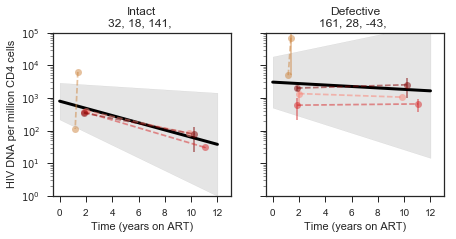

In [4]:
czl=['salmon','peru','tab:red','maroon',]#,'firebrick']
maxyr=12
simt=np.linspace(0,maxyr*12,100)

#cz=['magenta','indigo']
cz=['black','black']
titz=['Intact','Defective']
fig,axs=plt.subplots(1,2,sharex=True,sharey=True,figsize=(7,3))

for ii, dd in enumerate(['int','def']):
            
    #run MEM
    md = smf.mixedlm('l'+dd+' ~ ARTmo', dfmem, groups=dfmem['pid'])
    mdf = md.fit()
    mem_results=[mdf.params[1],mdf.conf_int().iloc[1,0],mdf.conf_int().iloc[1,1],
                 mdf.params[0],mdf.conf_int().iloc[0,0],mdf.conf_int().iloc[0,1]]
    
    print(mem_results[:3])
    print(-np.log(2)/mem_results[:3])

    for ip,p in enumerate(ppt4):
        tdf=dfmem[(dfmem['pid']==p)]
        #plt.plot(tdf['ARTmo']/12,tdf[dd],color=cz[ii],ls='--',marker='o',alpha=0.5)#cz_list[pind])
        axs[ii].errorbar(tdf['ARTmo']/12,tdf[dd],2*tdf[dd+'_sd'],color=czl[ip],ls='--',marker='o',alpha=0.5)#cz_list[pind])

    axs[ii].plot(simt/12,np.exp(mem_results[3]+mem_results[0]*simt),color=cz[ii],lw=3)
    axs[ii].fill_between(simt/12,np.exp(mem_results[4]+mem_results[1]*simt),np.exp(mem_results[5]+mem_results[2]*simt),color=cz[ii],alpha=0.1)
    
    hll=[]
    titzi = titz[ii]+'\n'
    for im in range(3):
        hll=str(int(-np.log(2)/mem_results[im]))
        titzi+=hll+', '
    
    axs[ii].set_title(titzi)
    axs[ii].set_xlabel('Time (years on ART)')

axs[0].set_ylabel('HIV DNA per million CD4 cells')

axs[ii].set_xticks(range(0,25,2))
plt.semilogy()
axs[ii].set_ylim([1,1e5])
plt.xlim([-0.5,maxyr+1])
#plt.legend()
#plt.tight_layout()    
plt.savefig('figures/IPDA.pdf',dpi=600)
